# Loading Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from secml.data.loader import CDataLoaderMNIST
from secml.data.splitter import CTrainTestSplit
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy, CMetricConfusionMatrix
from secml.adv.attacks.evasion import CAttackEvasionPGD
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from secml.data.splitter import CDataSplitter
from secml.array import CArray
import copy
from secml.data import CDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from secml.figure import CFigure

# PART- 1: Phase 1- Dataset Selection and Preprocessing

In [2]:
# Load and Preprocess MNIST
n_ts = 500  # number of testing samples
n_tr = 5000
loader = CDataLoaderMNIST()
train_set = loader.load('training', num_samples=n_tr)
ts = loader.load('testing', num_samples=n_ts)

splitter = CTrainTestSplit(train_size=0.7, random_state=42)
tr, val = splitter.split(train_set)

# # Normalize 
#Normalize
tr.X = tr.X / 255.0
val.X = val.X / 255.0
ts.X = ts.X / 255.0

# Print shapes
print("Train shape:", tr.X.shape)
print("Validation shape:", val.X.shape)
print("Test shape:", ts.X.shape)

Train shape: (3500, 784)
Validation shape: (1500, 784)
Test shape: (500, 784)


# PART- 1: Phase 2- Building a Machine Learning Model

In [3]:
# ML model architecture
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)  # Input layer: flatten image to 784
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)      # Hidden layer
        self.relu2 = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 10)       # Output layer: 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
        
    def extract_features(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)  # optional to exclude dropout for feature stability
        return x

# wrap in cclassifier from SecML lib
def create_cclassifier_pytorch(model, learning_rate: float = 0.01):
    clf =CClassifierPyTorch(
        model=model,
        input_shape=(1, 28, 28),
        softmax_outputs=True,
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        loss=nn.CrossEntropyLoss(),
        epochs=1,  # manual loop
        batch_size=128,
        random_state=42
    )
    return clf

# model training method with validation-based early stopping
def train_model(clf, tr, val, max_epochs=50, patience=10):
    best_acc = 0.0
    patience_counter = 0
    best_model = clf.deepcopy()

    for epoch in range(max_epochs):
        clf.fit(tr.X, tr.Y)
        
        val_pred = clf.predict(val.X)
        val_acc = CMetricAccuracy().performance_score(val.Y, val_pred)

        print(f"Epoch {epoch}: Val Acc = {val_acc:.2%}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = clf.deepcopy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    return best_model

## model trained on clean data

In [4]:
model = SimpleMLP()
# Move model to GPU
model = model.to('cuda') 
clf = create_cclassifier_pytorch(model)
clf = train_model(clf, tr, val)

Epoch 0: Val Acc = 34.87%
Epoch 1: Val Acc = 64.33%
Epoch 2: Val Acc = 77.20%
Epoch 3: Val Acc = 81.47%
Epoch 4: Val Acc = 86.00%
Epoch 5: Val Acc = 87.93%
Epoch 6: Val Acc = 88.73%
Epoch 7: Val Acc = 89.27%
Epoch 8: Val Acc = 89.80%
Epoch 9: Val Acc = 90.00%
Epoch 10: Val Acc = 90.33%
Epoch 11: Val Acc = 90.60%
Epoch 12: Val Acc = 90.87%
Epoch 13: Val Acc = 90.87%
Epoch 14: Val Acc = 91.13%
Epoch 15: Val Acc = 91.20%
Epoch 16: Val Acc = 91.53%
Epoch 17: Val Acc = 91.60%
Epoch 18: Val Acc = 91.47%
Epoch 19: Val Acc = 91.40%
Epoch 20: Val Acc = 91.53%
Epoch 21: Val Acc = 91.67%
Epoch 22: Val Acc = 91.87%
Epoch 23: Val Acc = 92.00%
Epoch 24: Val Acc = 92.00%
Epoch 25: Val Acc = 92.00%
Epoch 26: Val Acc = 92.20%
Epoch 27: Val Acc = 92.33%
Epoch 28: Val Acc = 92.33%
Epoch 29: Val Acc = 92.27%
Epoch 30: Val Acc = 92.33%
Epoch 31: Val Acc = 92.40%
Epoch 32: Val Acc = 92.67%
Epoch 33: Val Acc = 92.60%
Epoch 34: Val Acc = 92.67%
Epoch 35: Val Acc = 92.60%
Epoch 36: Val Acc = 92.53%
Epoch 37: V

## baseline performance evaluation

In [5]:
# Baseline Accuracy
ts_pred = clf.predict(ts.X)
ts_acc = CMetricAccuracy().performance_score(ts.Y, ts_pred)
print(f"Model accuracy on clean test data: {ts_acc:.2%}")


Model accuracy on clean test data: 91.60%


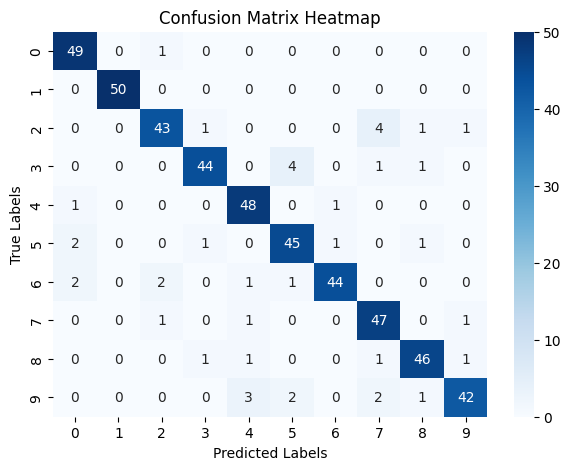

In [6]:
# confusion matrix
cm = CMetricConfusionMatrix()
conf_matrix = cm.performance_score(ts.Y, clf.predict(ts.X))
#print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix as heatmap
cm_array = conf_matrix.tondarray()

plt.figure(figsize=(7, 5))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# PART- 1: Phase 3- Training-Time Attacks (Data Poisoning)

## Poisoning Attack Implementation (label flipping)
## Flipped label with 15% attack budget

In [7]:
# label poisoning implementation method
def poison_labels(dataset, flip_rate=0.15):
    X_poisoned = dataset.X.deepcopy()
    Y_poisoned = dataset.Y.deepcopy()

    n_poison = int(flip_rate * Y_poisoned.size)
    poison_indices = np.random.choice(Y_poisoned.size, n_poison, replace=False)

    confusing_labels = {
        0: 6,  # 0 looks like 6
        1: 7,
        2: 3,
        3: 2,
        4: 9,
        5: 3,
        6: 0,
        7: 1,
        8: 9,
        9: 4
    }

    for idx in poison_indices:
        true_label = Y_poisoned[idx].item() 
        new_label = confusing_labels[true_label]
        Y_poisoned[idx] = new_label

    poisoned_dataset = CDataset(X_poisoned, Y_poisoned)
    return poisoned_dataset, poison_indices
    
# Poison training data (≤15%)
poisoned_tr, poisoned_indices = poison_labels(tr, flip_rate=0.15)   

## Poisoned Model Evaluation
## Retrain model with poison labels

In [8]:
poisoned_model = SimpleMLP()
# Move model to GPU
poisoned_model = poisoned_model.to('cuda') 
poisoned_clf = create_cclassifier_pytorch(poisoned_model)
poisoned_clf.fit(poisoned_tr.X, poisoned_tr.Y)

# poison model performance on clean test data
p_pred_test = poisoned_clf.predict(ts.X)
acc_p_test_clean = CMetricAccuracy().performance_score(ts.Y, p_pred_test)
print(f"Poison model Accuracy on Clean Test Set : {acc_p_test_clean:.2%}")


Poison model Accuracy on Clean Test Set : 15.00%


## Comparison of performance degradation 

In [9]:
# Poisoned validation samples from train poison data
idx_rows = CArray(poisoned_indices)
idx_cols = CArray.arange(tr.X.shape[1])  # all features

# Get sliced dataset
val_poison = poisoned_tr[idx_rows, idx_cols]

acc_p_val_poisoned = CMetricAccuracy().performance_score(val_poison.Y, poisoned_clf.predict(val_poison.X))

# Original (clean) validation set performance
acc_p_val_clean = CMetricAccuracy().performance_score(val.Y, poisoned_clf.predict(val.X))

# -----------------------------
# Step 4: Print Results
# -----------------------------
print(f"Poisoned Model Evaluation:")
print(f"→ Accuracy on Clean Test Set       : {acc_p_test_clean:.2%}")
print(f"→ Accuracy on Poisoned Val Samples : {acc_p_val_poisoned:.2%}")
print(f"→ Accuracy on Clean Val Set        : {acc_p_val_clean:.2%}")

Poisoned Model Evaluation:
→ Accuracy on Clean Test Set       : 15.00%
→ Accuracy on Poisoned Val Samples : 21.90%
→ Accuracy on Clean Val Set        : 14.13%


# PART- 1: Phase 4- Inference-Time Attacks (Adversarial Examples)

## White-box attack

In [10]:
#Adversarial Attack Generation
eps = 0.3

# white box attack 
pgd_attack = CAttackEvasionPGD(
    classifier=clf,
    double_init_ds= tr,
    dmax=eps,
    distance='l2',
    lb=0, ub=1,
    y_target=None
)

x_white_adv_labels, x_white_adv_scores, x_white_adv_dataset, _ = pgd_attack.run(ts.X, ts.Y)

# Evaluate model on adversarial samples
# clean model accuracy
print(f"Clean model accuracy on clean test set (baseline): {ts_acc:.2%}")

# Extract X_adv from the returned CDataset
X_adv_white = x_white_adv_dataset.X
Y_adv_white = x_white_adv_dataset.Y

# Predict using your classifier on adversarial examples
Y_pred_adv_white = clf.predict(X_adv_white)
adv_acc_white = CMetricAccuracy().performance_score(Y_adv_white, Y_pred_adv_white)
print(f"Clean model accuracy on white-box adversarial set: {adv_acc_white:.2%}")

acc_adv_whitebox = CMetricAccuracy().performance_score(ts.Y, Y_pred_adv_white)
print(f"White-box attack accuracy on target model: {acc_adv_whitebox:.2%}")

Clean model accuracy on clean test set (baseline): 91.60%
Clean model accuracy on white-box adversarial set: 80.80%
White-box attack accuracy on target model: 80.80%


## Black-box attack

In [11]:
# black box attack
# surrogate model is trained separately from the target model. Use surrogate model to generate adversarial examples.
blackbox_model = SimpleMLP()
blackbox_model = blackbox_model.to('cuda') 
surrogate_model = create_cclassifier_pytorch(blackbox_model)
surrogate_model.fit(tr.X, tr.Y)

blackbox_pgd = CAttackEvasionPGD(
    classifier=surrogate_model,
    double_init_ds= tr,
    distance='l2',
    dmax=eps,
    lb=0, ub=1,
    y_target=None,
)

X_black_adv_labels, x_black_adv_scores, x_black_adv_dataset, f_opt_blackbox = blackbox_pgd.run(ts.X, ts.Y)

# Extract X_adv from the returned CDataset
X_adv_black = x_black_adv_dataset.X
Y_adv_black = x_black_adv_dataset.Y

# Predict using your classifier on adversarial examples
Y_pred_adv_black = clf.predict(X_adv_black)
acc_adv_black = CMetricAccuracy().performance_score(Y_adv_black, Y_pred_adv_black)
print(f"Clean model accuracy on black-box adversarial set: {acc_adv_black:.2%}")

# Evaluate black-box adversarial samples on target model
acc_adv_blackbox = CMetricAccuracy().performance_score(ts.Y, clf.predict(X_adv_black))
print(f"Black-box attack accuracy on target model: {acc_adv_blackbox:.2%}")

Clean model accuracy on black-box adversarial set: 91.80%
Black-box attack accuracy on target model: 91.80%


## Generate adversarial test sets with controlled perturbation budgets (ε ≤ 0.1)

In [12]:
# Define perturbation budgets (ε values)
epsilons = [0.01, 0.03, 0.05, 0.08, 0.1]

# Initialize storage for adversarial datasets and accuracies
adv_sets_white = {}
adv_sets_black = {}
acc_white = []
acc_black = []

for eps in epsilons:
    print(f"\n--- Generating adversarial examples for ε = {eps} ---")

    ### WHITE-BOX ATTACK
    pgd_attack.dmax = eps
    _, _, adv_ds_white, _ = pgd_attack.run(ts.X, ts.Y)

    # Store generated dataset
    adv_sets_white[eps] = adv_ds_white

    # Evaluate on victim model
    y_pred_white = clf.predict(adv_ds_white.X)
    acc_w = CMetricAccuracy().performance_score(adv_ds_white.Y, y_pred_white)
    acc_white.append(acc_w)
    print(f"White-box Accuracy @ ε={eps}: {acc_w:.2%}")

    ### BLACK-BOX ATTACK
    blackbox_pgd.dmax = eps
    _, _, adv_ds_black, _ = blackbox_pgd.run(ts.X, ts.Y)

    # Store generated dataset
    adv_sets_black[eps] = adv_ds_black

    # Evaluate on victim model
    y_pred_black = clf.predict(adv_ds_black.X)
    acc_b = CMetricAccuracy().performance_score(adv_ds_black.Y, y_pred_black)
    acc_black.append(acc_b)
    print(f"Black-box Accuracy @ ε={eps}: {acc_b:.2%}")


--- Generating adversarial examples for ε = 0.01 ---
White-box Accuracy @ ε=0.01: 91.40%
Black-box Accuracy @ ε=0.01: 91.60%

--- Generating adversarial examples for ε = 0.03 ---
White-box Accuracy @ ε=0.03: 91.20%
Black-box Accuracy @ ε=0.03: 91.60%

--- Generating adversarial examples for ε = 0.05 ---
White-box Accuracy @ ε=0.05: 90.80%
Black-box Accuracy @ ε=0.05: 91.40%

--- Generating adversarial examples for ε = 0.08 ---
White-box Accuracy @ ε=0.08: 89.60%
Black-box Accuracy @ ε=0.08: 91.40%

--- Generating adversarial examples for ε = 0.1 ---
White-box Accuracy @ ε=0.1: 89.20%
Black-box Accuracy @ ε=0.1: 91.40%


## Attack Impact Analysis

### Adversarial success rate

In [13]:
#Robustness Metrics
# Accuracy on adversarial examples (white-box)
asr_whitebox = 1 - acc_adv_whitebox
print(f"White-box ASR: {asr_whitebox:.2%}")

# Accuracy on adversarial examples (black-box)
asr_blackbox = 1 - acc_adv_blackbox
print(f"Black-box ASR: {asr_blackbox:.2%}")

White-box ASR: 19.20%
Black-box ASR: 8.20%


### Confidence score distributions

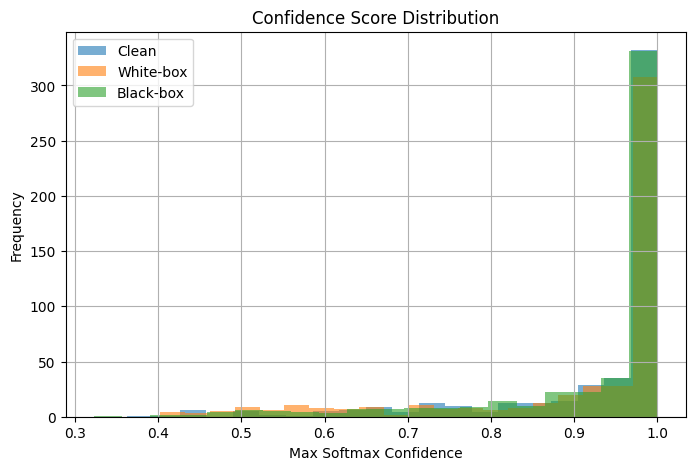

In [14]:
def get_confidence_scores(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X.tondarray(), dtype=torch.float32).to('cuda')
        logits = model(X_tensor)
        probs = F.softmax(logits, dim=1)
        confidences, _ = torch.max(probs, dim=1)  # max confidence for each sample
        return confidences.cpu().numpy()

# Clean confidence scores
conf_clean = get_confidence_scores(clf.model, ts.X)

# White-box adversarial scores
conf_whitebox = get_confidence_scores(clf.model, X_adv_white)

# Black-box adversarial scores
conf_blackbox = get_confidence_scores(clf.model, X_adv_black)

# Plot confidence distributions
plt.figure(figsize=(8, 5))
plt.hist(conf_clean, bins=20, alpha=0.6, label="Clean")
plt.hist(conf_whitebox, bins=20, alpha=0.6, label='White-box')
plt.hist(conf_blackbox, bins=20, alpha=0.6, label='Black-box')
plt.title("Confidence Score Distribution")
plt.xlabel("Max Softmax Confidence")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Per-class vulnerability analysis

In [15]:
from collections import Counter

vulnerable_per_class_white = {}

for cls in range(10):
    mask = ts.Y == cls
    clean_correct = (ts_pred[mask] == ts.Y[mask]).sum()
    adv_correct = (Y_pred_adv_white[mask] == ts.Y[mask]).sum()
    drop = (clean_correct - adv_correct) / clean_correct if clean_correct > 0 else 0
    vulnerable_per_class_white[cls] = drop

print("Per-class vulnerability drop (white-box):")
for k, v in vulnerable_per_class_white.items():
    print(f"Class {k}: {v:.2%}")


Per-class vulnerability drop (white-box):
Class 0: 8.16%
Class 1: 0.00%
Class 2: 4.65%
Class 3: 20.45%
Class 4: 2.08%
Class 5: 17.78%
Class 6: 9.09%
Class 7: 21.28%
Class 8: 13.04%
Class 9: 23.81%


In [16]:
vulnerable_per_class_black = {}

for cls in range(10):
    mask = ts.Y == cls
    clean_correct = (ts_pred[mask] == ts.Y[mask]).sum()
    adv_correct = (Y_pred_adv_black[mask] == ts.Y[mask]).sum()
    drop = (clean_correct - adv_correct) / clean_correct if clean_correct > 0 else 0
    vulnerable_per_class_black[cls] = drop

print("\nPer-class vulnerability drop (black-box):")
for k, v in vulnerable_per_class_black.items():
    print(f"Class {k}: {v:.2%}")


Per-class vulnerability drop (black-box):
Class 0: 0.00%
Class 1: 0.00%
Class 2: -2.33%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 2.27%
Class 7: 0.00%
Class 8: -2.17%
Class 9: 0.00%


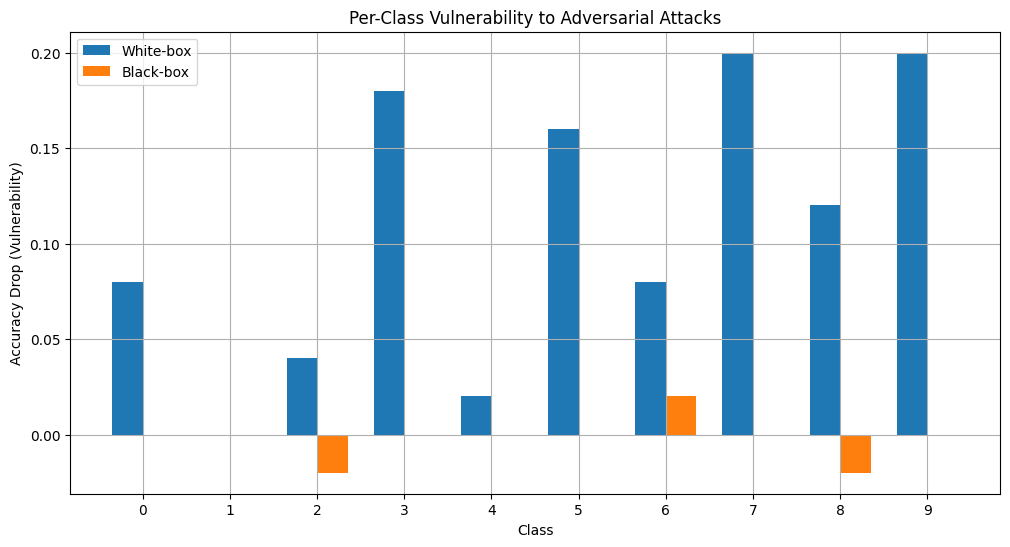

In [17]:
def per_class_accuracy(y_true, y_pred):
    y_true = y_true.tondarray()
    y_pred = y_pred.tondarray()
    
    class_ids = np.unique(y_true)
    acc_per_class = {}
    
    for cls in class_ids:
        idx = np.where(y_true == cls)[0]
        acc = np.mean(y_pred[idx] == y_true[idx])
        acc_per_class[int(cls)] = acc
    return acc_per_class

# Per-class accuracies
acc_clean = per_class_accuracy(ts.Y, ts_pred)
acc_white_per_class = per_class_accuracy(ts.Y, Y_pred_adv_white)
acc_black_per_class = per_class_accuracy(ts.Y, Y_pred_adv_black)

vuln_white = {cls: acc_clean[cls] - acc_white_per_class[cls] for cls in acc_clean}
vuln_black = {cls: acc_clean[cls] - acc_black_per_class[cls] for cls in acc_clean}

classes = list(acc_clean.keys())
v_white = [vuln_white[cls] for cls in classes]
v_black = [vuln_black[cls] for cls in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, v_white, width, label='White-box')
plt.bar(x + width/2, v_black, width, label='Black-box')
plt.xlabel("Class")
plt.ylabel("Accuracy Drop (Vulnerability)")
plt.title("Per-Class Vulnerability to Adversarial Attacks")
plt.xticks(x, classes)
plt.legend()
plt.grid(True)
plt.show()

# PART- 1: Phase 5: Comprehensive Evaluation

## Cross-Attack Susceptibility

### Test poisoned model against unseen attack vectors

In [18]:
#  Cross-Attack Susceptibility
# the poisoned model was trained with label flipping, test it with PGD adversarial examples
pgd_attack_unseen = CAttackEvasionPGD(
    classifier=poisoned_clf,
    distance='l2',
    dmax=0.1,
    lb=0, ub=1,
    y_target=None,
    double_init_ds=tr  # or a small subset
)

X_adv_unseen_labels, _, adv_dataset_unseen, _ = pgd_attack_unseen.run(ts.X, ts.Y)
X_adv_unseen = adv_dataset_unseen.X
Y_adv_unseen = adv_dataset_unseen.Y

Y_pred_unseen = poisoned_clf.predict(X_adv_unseen)
acc_unseen = CMetricAccuracy().performance_score(Y_adv_unseen, Y_pred_unseen)

print(f"Accuracy under Unseen Attack: {acc_unseen:.2%}")
print(f"Cross-Attack Success Rate: {1 - acc_unseen:.2%}")

acc_clean = CMetricAccuracy().performance_score(ts.Y, clf.predict(X_adv_unseen))
print(f"Clean Model Accuracy under Unseen Attack: {acc_clean:.2%}")

Accuracy under Unseen Attack: 14.80%
Cross-Attack Success Rate: 85.20%
Clean Model Accuracy under Unseen Attack: 91.60%


### Analyze transferability between attack methods

In [19]:
pgd_blackbox = CAttackEvasionPGD(
    classifier=surrogate_model,
    distance='l2',
    dmax=0.1,
    lb=0, ub=1,
    y_target=None,
    double_init_ds=ts
)

_, _, adv_data_blackbox, _ = pgd_blackbox.run(ts.X, ts.Y)
X_adv_blackbox = adv_data_blackbox.X
Y_adv_blackbox = adv_data_blackbox.Y

In [20]:
pgd_whitebox = CAttackEvasionPGD(
    classifier=clf,
    distance='l2',
    dmax=0.1,
    lb=0, ub=1,
    y_target=None,
    double_init_ds=ts
)

_, _, adv_data_whitebox, _ = pgd_whitebox.run(ts.X, ts.Y)
X_adv_whitebox = adv_data_whitebox.X
Y_adv_whitebox = adv_data_whitebox.Y

In [21]:
# 1. Transfer from surrogate to victim (black-box attack)
acc_blackbox_on_target = CMetricAccuracy().performance_score(ts.Y, clf.predict(X_adv_blackbox))
asr_blackbox = 1 - acc_blackbox_on_target

# 2. Transfer from victim to surrogate (optional)
acc_whitebox_on_surrogate = CMetricAccuracy().performance_score(ts.Y, surrogate_model.predict(X_adv_whitebox))
asr_whitebox_on_surrogate = 1 - acc_whitebox_on_surrogate

print(f"ASR of black-box attack on victim: {asr_blackbox:.2%}")
print(f"ASR of white-box attack on surrogate: {asr_whitebox_on_surrogate:.2%}")

ASR of black-box attack on victim: 8.60%
ASR of white-box attack on surrogate: 60.20%


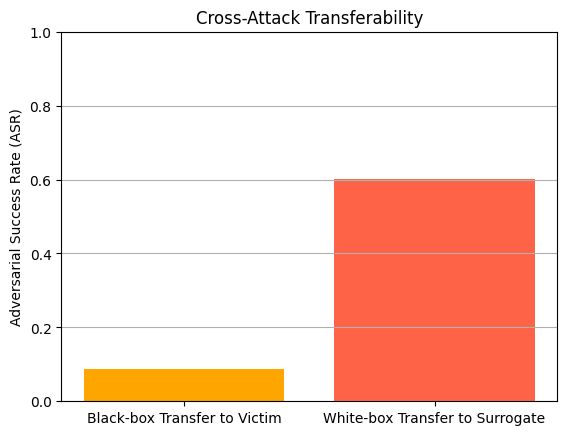

In [22]:
asr_scores = [asr_blackbox, asr_whitebox_on_surrogate]
labels = ["Black-box Transfer to Victim", "White-box Transfer to Surrogate"]

plt.bar(labels, asr_scores, color=['orange', 'tomato'])
plt.ylabel("Adversarial Success Rate (ASR)")
plt.title("Cross-Attack Transferability")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

## Vulnerability Report

### Security Curve for accuracy with both perturbations number and number of poisoned samples

epsilons: 5
acc_white: 5
acc_black: 5


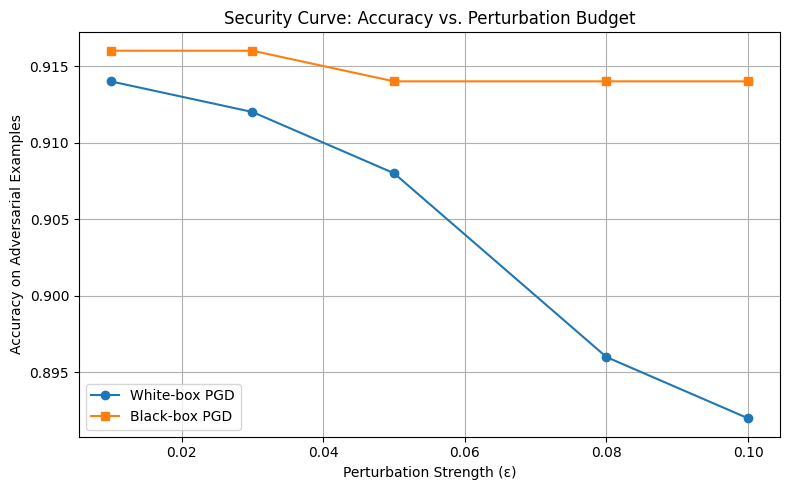

In [23]:
import matplotlib.pyplot as plt

print("epsilons:", len(epsilons))
print("acc_white:", len(acc_white))
print("acc_black:", len(acc_black))

plt.figure(figsize=(8, 5))
plt.plot(epsilons, acc_white, label='White-box PGD', marker='o')
plt.plot(epsilons, acc_black, label='Black-box PGD', marker='s')
plt.xlabel("Perturbation Strength (ε)")
plt.ylabel("Accuracy on Adversarial Examples")
plt.title("Security Curve: Accuracy vs. Perturbation Budget")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Document failure modes and high-risk decision boundaries

### Identify Failure Cases

In [24]:
def get_failure_cases(model, X, Y, threshold=0.5):
    from torch.nn.functional import softmax

    X_tensor = torch.tensor(X.tondarray(), dtype=torch.float32).to('cuda')
    logits = model(X_tensor)
    probs = softmax(logits, dim=1)
    max_conf, preds = torch.max(probs, dim=1)
    
    Y_true = Y.tondarray()
    preds_np = preds.detach().cpu().numpy()
    conf_np = max_conf.detach().cpu().numpy()
    
    incorrect_mask = preds_np != Y_true
    low_conf_mask = conf_np < threshold

    failure_indices = np.where(incorrect_mask | low_conf_mask)[0]
    return failure_indices, preds_np[failure_indices], conf_np[failure_indices]

from collections import defaultdict
def group_failures_by_class(indices, true_labels, pred_labels, conf_scores):
    grouped = defaultdict(list)
    for i, idx in enumerate(indices):
        cls = int(true_labels[idx])
        grouped[cls].append(float(conf_scores[i]))
    return grouped
    
y_true_np = ts.Y.tondarray()

# Failures on clean data
fail_clean_idx, fail_clean_pred, fail_clean_conf = get_failure_cases(clf.model, ts.X, ts.Y)
grouped_clean = group_failures_by_class(fail_clean_idx, y_true_np, fail_clean_pred, fail_clean_conf)

# Failures on white-box adversarial
fail_white_idx, fail_white_pred, fail_white_conf = get_failure_cases(clf.model, X_adv_whitebox, ts.Y)
grouped_white = group_failures_by_class(fail_white_idx, y_true_np, fail_white_pred, fail_white_conf)

# Failures on black-box adversarial
fail_black_idx, fail_black_pred, fail_black_conf = get_failure_cases(clf.model, X_adv_blackbox, ts.Y)
grouped_black = group_failures_by_class(fail_black_idx, y_true_np, fail_black_pred, fail_black_conf)

def plot_failure_summary(grouped_failures, title="Failure Summary", class_names=None):
    classes = sorted(grouped_failures.keys())
    counts = [len(grouped_failures[c]) for c in classes]
    avg_conf = [np.mean(grouped_failures[c]) for c in classes]

    # X labels
    x_labels = [class_names[c] if class_names else str(c) for c in classes]
    x = np.arange(len(classes))

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Bar plot: failure count
    ax1.bar(x, counts, color='skyblue', label='Failure Count')
    ax1.set_ylabel('Failure Count')
    ax1.set_xlabel('True Class')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.set_title(title)
    ax1.grid(axis='y')

    # Line plot: average confidence
    ax2 = ax1.twinx()
    ax2.plot(x, avg_conf, color='tomato', marker='o', label='Avg. Confidence')
    ax2.set_ylabel('Average Confidence')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()


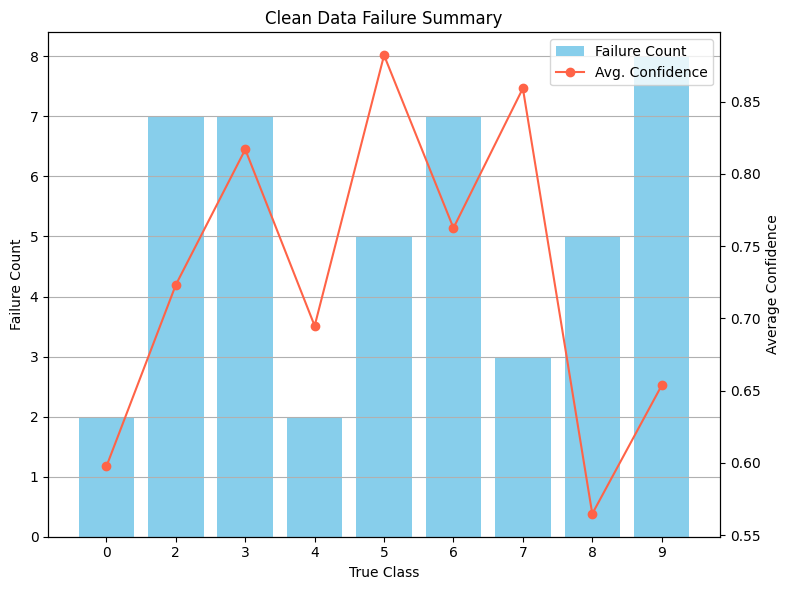

In [25]:
plot_failure_summary(grouped_clean, title="Clean Data Failure Summary")

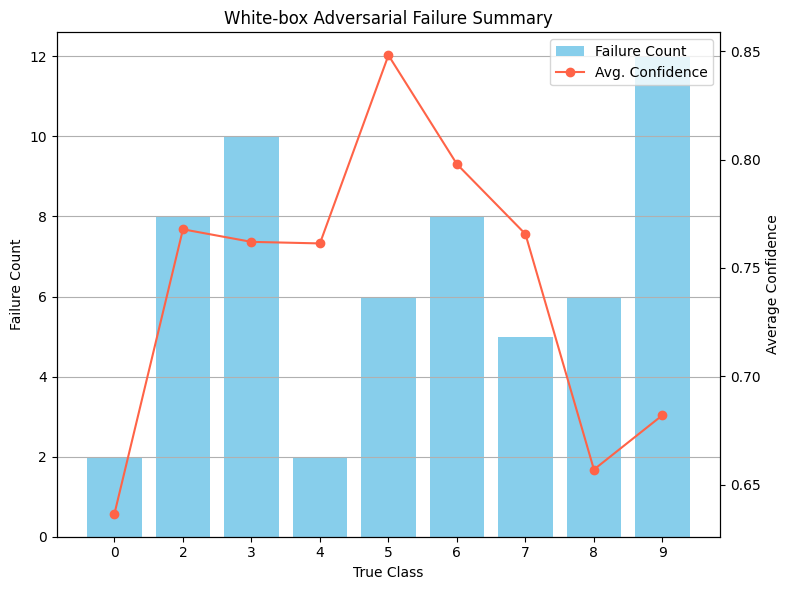

In [26]:
plot_failure_summary(grouped_white, title="White-box Adversarial Failure Summary")

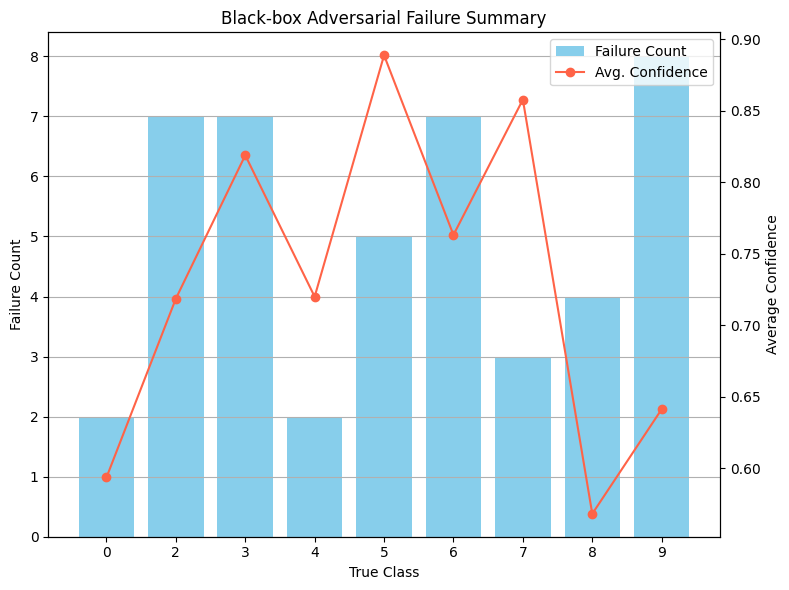

In [27]:
plot_failure_summary(grouped_black, title="Black-box Adversarial Failure Summary")

### Visualize High-Risk Boundaries

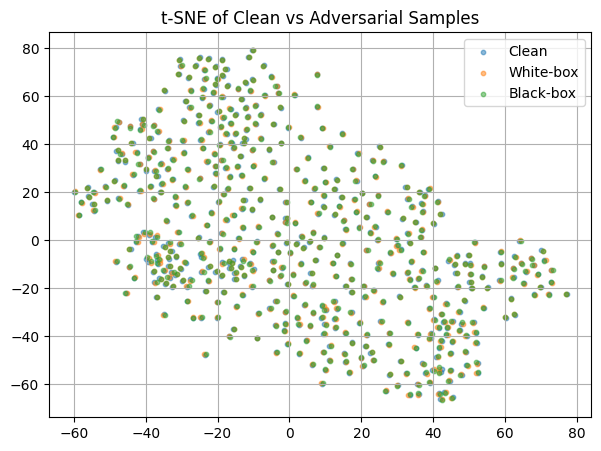

In [28]:
from sklearn.manifold import TSNE
X_all = np.vstack([
    ts.X.tondarray(),
    X_adv_whitebox.tondarray(),
    X_adv_blackbox.tondarray()
])
Y_all = np.hstack([
    ts.Y.tondarray(),
    ts.Y.tondarray(),
    ts.Y.tondarray()
])

attack_type = ['Clean'] * ts.Y.size + ['White-box'] * ts.Y.size + ['Black-box'] * ts.Y.size

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_all)

plt.figure(figsize=(7, 5))
for attack in ['Clean', 'White-box', 'Black-box']:
    idx = [i for i, a in enumerate(attack_type) if a == attack]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=attack, alpha=0.5, s=10)

plt.title("t-SNE of Clean vs Adversarial Samples")
plt.legend()
plt.grid(True)
plt.show()

# PART- 2: Phase 1: Poisoning Defense Implementation

## Implement anomaly detection 

In [29]:
# 1. Anomaly Detection using Isolation Forest

from sklearn.ensemble import IsolationForest
from secml.array import CArray
from secml.data import CDataset

# Convert features to NumPy
X_train_np = tr.X.tondarray()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso_forest.fit_predict(X_train_np)

# -1 = anomaly, 1 = normal
normal_indices = CArray((outlier_preds == 1).nonzero()[0])
anomaly_indices = CArray((outlier_preds == -1).nonzero()[0])

# Filter out suspicious points
tr_defended_iso = tr[normal_indices, CArray.arange(tr.X.shape[1])]

print(f"Original training size: {tr.num_samples}")
print(f"Filtered training size after Isolation Forest: {tr_defended_iso.num_samples}")

Original training size: 3500
Filtered training size after Isolation Forest: 3325


## Spectral Signature Analysis for poisoned sample removal

In [30]:
# 2. Spectral Signature Analysis 
import torch
from sklearn.decomposition import TruncatedSVD

def extract_hidden_features(model, X_carray):
    # Convert to torch tensor
    X_tensor = torch.tensor(X_carray.tondarray(), dtype=torch.float32).to('cuda')
    model.eval()
    with torch.no_grad():
        features = model.extract_features(X_tensor)
    return features.cpu().numpy()

def spectral_signature_analysis(model, tr_dataset, percentile=95):
    suspicious_indices = []

    for cls in tr_dataset.Y.unique():
        class_mask = tr_dataset.Y == cls
        X_class = tr_dataset.X[class_mask, :]
        indices = CArray.arange(tr_dataset.num_samples)[class_mask]
    
        feats = extract_hidden_features(model, X_class)
    
        svd = TruncatedSVD(n_components=1)
        proj = svd.fit_transform(feats)
        scores = proj[:, 0]
        threshold = np.percentile(scores, percentile)
    
        outlier_mask = scores > threshold
        outlier_indices = CArray(indices.tondarray()[outlier_mask])
        suspicious_indices += outlier_indices.tolist()

    return CArray(suspicious_indices)

suspicious_idx = spectral_signature_analysis(clf._model, tr, percentile=95)
clean_idx = CArray(list(set(range(tr.num_samples)) - set(suspicious_idx.tolist())))

# Cleaned training dataset
tr_defended_spec = tr[clean_idx, CArray.arange(tr.X.shape[1])]
print(f"Training set after spectral signature defense: {tr_defended_spec.num_samples}")

Training set after spectral signature defense: 3320


## Robust Training Methods 

### Integrate regularization by Weight Clipping

In [31]:
# •	Integrate regularization

def apply_weight_clipping(pytorch_model, clip_value=1.0):
    for param in pytorch_model.parameters():
        if param.requires_grad:
            param.data.clamp_(-clip_value, clip_value)

def train_model_with_weight_clipping(clf, tr, val, max_epochs=50, patience=10, clip_value=1.0):
    best_acc = 0.0
    patience_counter = 0
    best_model = clf.deepcopy()

    for epoch in range(max_epochs):
        clf.fit(tr.X, tr.Y)

        # Apply weight clipping after training on each epoch
        apply_weight_clipping(clf._model, clip_value=clip_value)
        
        val_pred = clf.predict(val.X)
        val_acc = CMetricAccuracy().performance_score(val.Y, val_pred)

        print(f"Epoch {epoch}: Val Acc = {val_acc:.2%}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = clf.deepcopy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return best_model

trained_clf = train_model_with_weight_clipping(clf, tr_defended_spec, val, clip_value=1.0)

preds = trained_clf.predict(ts.X)
acc = CMetricAccuracy().performance_score(ts.Y, preds)
print(f"Model with weight clipping Test Accuracy: {acc:.2%}")

Epoch 0: Val Acc = 92.87%
Epoch 1: Val Acc = 92.80%
Epoch 2: Val Acc = 92.73%
Epoch 3: Val Acc = 92.60%
Epoch 4: Val Acc = 92.53%
Epoch 5: Val Acc = 92.53%
Epoch 6: Val Acc = 92.53%
Epoch 7: Val Acc = 92.40%
Epoch 8: Val Acc = 92.27%
Epoch 9: Val Acc = 92.00%
Epoch 10: Val Acc = 91.87%
Early stopping triggered.
Model with weight clipping Test Accuracy: 91.80%


### Private Training

In [32]:
#!pip install opacus

### Model architecture implementation

In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

def train_dp_model(model, X_train, Y_train, X_val, Y_val,
                   epochs=10, batch_size=64, lr=1e-3,
                   epsilon=5.0, delta=1e-5, max_grad_norm=1.0):

    # Ensure model is compatible with Opacus
    model = ModuleValidator.fix(model)
    ModuleValidator.validate(model, strict=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Convert CDataset to Tensor
    X_tensor = torch.tensor(X_train.tondarray(), dtype=torch.float32)
    Y_tensor = torch.tensor(Y_train.tondarray(), dtype=torch.long)

    train_dataset = TensorDataset(X_tensor, Y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Attach Privacy Engine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        target_epsilon=epsilon,
        target_delta=delta,
        epochs=epochs,
        max_grad_norm=max_grad_norm,
    )

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"[DP-Epoch {epoch+1}] Loss: {epoch_loss:.2%}")

    return model

### performance evaluation

In [34]:
from secml.ml.peval.metrics import CMetricAccuracy

def evaluate_torch_model(model, X_test, Y_test, name="DP Model"):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test.tondarray(), dtype=torch.float32).to('cuda')
        outputs = model(inputs).argmax(dim=1).cpu().numpy()
        acc = CMetricAccuracy().performance_score(Y_test, CArray(outputs))
    print(f"{name} Accuracy: {acc:.2%}")
    return acc

### model training

In [35]:
m = SimpleMLP()
m = m.to('cuda') 
dp_model = train_dp_model(m, tr.X, tr.Y, val.X, val.Y)

# Step 2: Evaluate
evaluate_torch_model(dp_model, ts.X, ts.Y, name="DP Model on Test Set")

2025-07-30 15:31:11,822 - py.warnings - WARNING - D:\FanshaweWork\Semester2\MLSecurity\MLsecurity_venv\lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(

2025-07-30 15:31:11,839 - py.warnings - WARNING - D:\FanshaweWork\Semester2\MLSecurity\MLsecurity_venv\lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(

[DP-Epoch 1] Loss: 12536.51%
[DP-Epoch 2] Loss: 12157.12%
[DP-Epoch 3] Loss: 11542.95%
[DP-Epoch 4] Loss: 10646.90%
[DP-Epoch 5] Loss: 9642.65%
[DP-Epoch 6] Loss: 8442.15%
[DP-Epoch 7] Loss: 7544.95%
[DP-Epoch 8] Loss: 6855.68%
[DP-Epoch 9] Loss: 6170.03%
[DP-Epoch 10] Loss: 5681.54%
DP Model

0.694

# PART- 2: Phase 2- Adversarial Defense Strategies

##	Input Preprocessing Defenses (randomized smoothing techniques)

In [36]:
# Input Preprocessing Defense: Randomized Smoothing
def randomized_smoothing_predict(clf, X, num_samples=100, sigma=0.25, vote=True):
    """
    clf         : CClassifierPyTorch
    X           : CArray test samples
    num_samples : Number of noisy samples per input
    sigma       : Standard deviation of Gaussian noise
    vote        : True=majority vote, False=confidence averaging
    """
    X_np = X.tondarray()
    num_classes = clf.n_classes
    preds_all = []

    for i in range(X_np.shape[0]):
        x = X_np[i]
        x_noisy = np.repeat(x[np.newaxis, :], num_samples, axis=0)
        noise = np.random.normal(loc=0.0, scale=sigma, size=x_noisy.shape)
        x_noisy += noise
        x_noisy = np.clip(x_noisy, 0, 1)  # ensure within valid range

        x_noisy_tensor = torch.tensor(x_noisy, dtype=torch.float32).to('cuda')
        with torch.no_grad():
            logits = clf._model(x_noisy_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

        if vote:
            pred_labels = np.argmax(probs, axis=1)
            counts = np.bincount(pred_labels, minlength=num_classes)
            final_pred = np.argmax(counts)
        else:
            avg_probs = np.mean(probs, axis=0)
            final_pred = np.argmax(avg_probs)

        preds_all.append(final_pred)

    return CArray(preds_all)

### Evaluate accuracy for model with smoothing technique

In [37]:
# Evaluate clean accuracy with smoothing
Y_smooth_pred = randomized_smoothing_predict(clf, ts.X, num_samples=100, sigma=0.25, vote=True)
acc_smooth = CMetricAccuracy().performance_score(ts.Y, Y_smooth_pred)

print(f"Randomized Smoothing Accuracy (Clean): {acc_smooth:.2%}")

Randomized Smoothing Accuracy (Clean): 84.60%


In [38]:
Y_adv_smooth_pred_white = randomized_smoothing_predict(clf, X_adv_white, num_samples=100, sigma=0.25, vote=True)
acc_adv_smooth_white = CMetricAccuracy().performance_score(ts.Y, Y_adv_smooth_pred_white)
print(f"Randomized Smoothing Accuracy (White-box): {acc_adv_smooth_white:.2%}")

Randomized Smoothing Accuracy (White-box): 79.00%


In [39]:
Y_adv_smooth_pred_black = randomized_smoothing_predict(clf, X_adv_black, num_samples=100, sigma=0.25, vote=True)
acc_adv_smooth_black = CMetricAccuracy().performance_score(ts.Y, Y_adv_smooth_pred_black)
print(f"Randomized Smoothing Accuracy (Black-box): {acc_adv_smooth_black:.2%}")

Randomized Smoothing Accuracy (Black-box): 82.80%


## Model Hardening

## Apply adversarial training with PGD examples

In [40]:
# Model Hardening
# Apply adversarial training with PGD examples

def generate_pgd_adversarial(clf, tr, eps=0.1):
    pgd = CAttackEvasionPGD(
        classifier=clf,
        double_init_ds=tr,
        distance='l2',
        dmax=eps,
        lb=0, ub=1,
        y_target=None
    )
    adv_labels, adv_scores, adv_dataset, f_opt = pgd.run(tr.X, tr.Y)
    return adv_dataset

def adversarial_train_model(clf, tr, val, X_adv, Y_adv, max_epochs=30, patience=5, eps=0.1):
    best_model = clf.deepcopy()
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(max_epochs):
        print(f"\nEpoch {epoch}")

        X_combined = CArray.concatenate(tr.X, X_adv, axis=0)  
        Y_combined = CArray.concatenate(tr.Y, Y_adv, axis=0)    
        
        # Create augmented training dataset from scratch
        tr_aug = CDataset(X_combined, Y_combined)

        # Train on adversarial + clean data
        clf.fit(tr_aug.X, tr_aug.Y)

        # Validate
        val_pred = clf.predict(val.X)
        val_acc = CMetricAccuracy().performance_score(val.Y, val_pred)
        print(f"Val Accuracy: {val_acc:.2%}")

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = clf.deepcopy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return best_model


In [41]:
hardening_model = SimpleMLP()
hardening_model = hardening_model.to('cuda') 
hardening_clf = create_cclassifier_pytorch(hardening_model)
hardening_clf.fit(tr.X, tr.Y)


SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [42]:
# Generate PGD adversarial examples from current model
adv_dataset_hardening = generate_pgd_adversarial(hardening_clf, tr) 

In [43]:
hardening_clf = adversarial_train_model(hardening_clf, tr, val, adv_dataset_hardening.X, adv_dataset_hardening.Y, max_epochs=20, eps=0.1)


Epoch 0
Val Accuracy: 76.07%

Epoch 1
Val Accuracy: 86.53%

Epoch 2
Val Accuracy: 88.93%

Epoch 3
Val Accuracy: 89.80%

Epoch 4
Val Accuracy: 90.13%

Epoch 5
Val Accuracy: 90.53%

Epoch 6
Val Accuracy: 90.80%

Epoch 7
Val Accuracy: 91.20%

Epoch 8
Val Accuracy: 91.33%

Epoch 9
Val Accuracy: 91.60%

Epoch 10
Val Accuracy: 91.87%

Epoch 11
Val Accuracy: 91.93%

Epoch 12
Val Accuracy: 91.93%

Epoch 13
Val Accuracy: 92.13%

Epoch 14
Val Accuracy: 92.20%

Epoch 15
Val Accuracy: 92.13%

Epoch 16
Val Accuracy: 92.13%

Epoch 17
Val Accuracy: 92.20%

Epoch 18
Val Accuracy: 92.20%

Epoch 19
Val Accuracy: 92.33%


In [44]:
# Clean test
Y_pred_clean = hardening_clf.predict(ts.X)
acc_clean_hardening = CMetricAccuracy().performance_score(ts.Y, Y_pred_clean)
print(f"[Hardening] Accuracy on Clean Test Set: {acc_clean_hardening:.2%}")

X_adv_test = generate_pgd_adversarial(hardening_clf, ts)

Y_pred_adv = hardening_clf.predict(X_adv_test.X)
acc_adv_hardening = CMetricAccuracy().performance_score(ts.Y, Y_pred_adv)

print(f"[Hardening] Accuracy on PGD Adversarial Test Set: {acc_adv_hardening:.2%}")

[Hardening] Accuracy on Clean Test Set: 90.60%
[Hardening] Accuracy on PGD Adversarial Test Set: 87.80%


In [45]:
# Clean accuracy before defense
acc_clean_before = CMetricAccuracy().performance_score(ts.Y, clf.predict(ts.X))

# PGD attack on baseline
X_adv_before = generate_pgd_adversarial(clf, ts)
acc_adv_before = CMetricAccuracy().performance_score(ts.Y, clf.predict(X_adv_before.X))

print(f"[Baseline] Clean Accuracy: {acc_clean_before:.2%}")
print(f"[Baseline] PGD Adversarial Accuracy: {acc_adv_before:.2%}")

[Baseline] Clean Accuracy: 92.00%
[Baseline] PGD Adversarial Accuracy: 89.20%


### Explore certified robustness methods 

In [46]:
#	Explore certified robustness methods (IBP/RS-Certify)
class IBPMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256], num_classes=10):
        super(IBPMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def bound_forward(self, x, eps):
        # Interval Bound Propagation (IBP)
        x = self.flatten(x)
        lower = x - eps
        upper = x + eps

        def ibp_linear(layer, l, u):
            W = layer.weight
            b = layer.bias
            W_pos = torch.clamp(W, min=0)
            W_neg = torch.clamp(W, max=0)
            l_out = F.linear(l, W_pos) + F.linear(u, W_neg) + b
            u_out = F.linear(u, W_pos) + F.linear(l, W_neg) + b
            return l_out, u_out

        l1, u1 = ibp_linear(self.fc1, lower, upper)
        l1, u1 = F.relu(l1), F.relu(u1)

        l2, u2 = ibp_linear(self.fc2, l1, u1)
        l2, u2 = F.relu(l2), F.relu(u2)

        l3, u3 = ibp_linear(self.fc3, l2, u2)
        return l3, u3  # certified lower and upper bounds of logits

def evaluate_certified_robustness_IBP(model, cdataset, epsilon):
    model.eval()
    total_certified = 0
    total = 0

    X = torch.tensor(cdataset.X.tondarray(), dtype=torch.float32).to("cuda")
    Y = torch.tensor(cdataset.Y.tondarray(), dtype=torch.long).to("cuda")

    l_bounds, u_bounds = model.bound_forward(X, eps=epsilon)

    for i in range(len(Y)):
        true_class = Y[i]
        l_true = l_bounds[i, true_class]
        u_others = torch.cat([u_bounds[i, :true_class], u_bounds[i, true_class+1:]])
        if l_true > u_others.max():
            total_certified += 1
        total += 1

    certified_acc = total_certified / total
    print(f"Certified Robust Accuracy (IBP) (ε={epsilon}): {certified_acc:.2%}")
    return certified_acc

In [47]:
# Initialize and train model
model_IBP = IBPMLP().cuda()

# Evaluate certified robustness
certified_acc_IBP = evaluate_certified_robustness_IBP(model_IBP, ts, epsilon=0.1)

Certified Robust Accuracy (IBP) (ε=0.1): 0.00%


We explored certified robustness methods, particularly Interval Bound Propagation (IBP), which provides provable guarantees that the model's predictions remain unchanged under bounded perturbations. We implemented an IBP-compatible neural network and evaluated its certified robust accuracy. However, without specialized IBP training, the model achieved 0% certified accuracy under ε=0.1. This highlights the importance of integrating IBP-specific loss during training. Additionally, methods like RS-Certify offer another approach using randomized smoothing to certify model robustness with probabilistic guarantees.

# PART- 2: Phase 3- Defense Evaluation

## Quantitative Analysis

### Clean Data Accuracy Preservation

In [48]:
# Clean test accuracy before defenses
acc_clean_baseline = CMetricAccuracy().performance_score(ts.Y, clf.predict(ts.X))
print(f"[Before Defense] Clean Accuracy: {acc_clean_baseline:.2%}")
print(f"[After Smoothing ] Clean Accuracy: {acc_smooth:.2%}")
print(f"[After Hardening] Clean Accuracy: {acc_clean_hardening:.2%}")

[Before Defense] Clean Accuracy: 92.00%
[After Smoothing ] Clean Accuracy: 84.60%
[After Hardening] Clean Accuracy: 90.60%


### Attack Success Rate Reduction

In [49]:
# Before Defense
print(f"[Before Defense] White-box Accuracy: {acc_adv_whitebox:.2%}")
print(f"[Before Defense] Black-box Accuracy: {acc_adv_blackbox:.2%}")

# After Randomized Smoothing
print(f"[After Smoothing] White-box Accuracy: {acc_adv_smooth_white:.2%}")
print(f"[After Smoothing] Black-box Accuracy: {acc_adv_smooth_black:.2%}")

# After Adversarial Training
print(f"[After Hardening] White-box Accuracy: {acc_adv_hardening:.2%}")

[Before Defense] White-box Accuracy: 80.80%
[Before Defense] Black-box Accuracy: 91.80%
[After Smoothing] White-box Accuracy: 79.00%
[After Smoothing] Black-box Accuracy: 82.80%
[After Hardening] White-box Accuracy: 87.80%


### Computational Overhead (Timing Evaluation)

In [50]:
import time

def measure_inference_time(predict_func, X):
    start = time.time()
    _ = predict_func(X)
    return time.time() - start

idx_rows = CArray.arange(10)                 # First 10 rows
idx_cols = CArray.arange(ts.X.shape[1])      # All columns

subset_X = ts.X[idx_rows, idx_cols]          # Proper 2D indexing

baseline_time = measure_inference_time(lambda x: clf.predict(x), ts.X)
smooth_time = measure_inference_time(lambda x: randomized_smoothing_predict(clf, x), subset_X)  # fewer samples for speed
hardening_time = measure_inference_time(lambda x: hardening_clf.predict(x), ts.X)

print(f"Inference Time [Baseline]: {baseline_time:.2f}s")
print(f"Inference Time [Smoothing]: {smooth_time:.2f}s (10 samples)")
print(f"Inference Time [Hardening]: {hardening_time:.2f}s")

Inference Time [Baseline]: 0.03s
Inference Time [Smoothing]: 0.05s (10 samples)
Inference Time [Hardening]: 0.04s


## Qualitative Analysis

### Visualize Decision Boundary Changes

To visualize decision boundary changes before and after model hardening, I need a 2D dataset. Since my current dataset MINST is high-dimensional, decision boundaries cannot be directly visualized. So, I implemented decision boundary from scratch using a 2D toy dataset (like make_moons), and show how hardening affects the boundary.

In [51]:
# Prepare Toy 2D Dataset
from sklearn.datasets import make_moons
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF
from secml.ml.peval.metrics import CMetricAccuracy

# Generate 2D data
X_toy, y_toy = make_moons(n_samples=500, noise=0.2, random_state=42)
toy_dataset = CDataset(CArray(X_toy), CArray(y_toy))

# Split into train and test
splitter = CTrainTestSplit(train_size=0.7, random_state=42)
tr_toy, ts_toy = splitter.split(toy_dataset)

#Train Clean Model (Before Defense)

# Initial model
clf_boundary = CClassifierSVM(kernel=CKernelRBF(), C=1.0)
clf_boundary.fit(tr_toy.X, tr_toy.Y)

# Evaluate
acc_clean_boundary = CMetricAccuracy().performance_score(ts_toy.Y, clf_boundary.predict(ts_toy.X))
print(f"Clean Accuracy (Before Defense): {acc_clean_boundary:.2%}")

# Adversarial Attack (PGD)
pgd_boundary = CAttackEvasionPGD(
    classifier=clf_boundary,
    double_init_ds=ts_toy,
    distance='l2',
    dmax=0.5,
    lb=ts_toy.X.min(), ub=ts_toy.X.max()
)

adv_labels_boundary, adv_scores_boundary, adv_ds_boundary, _ = pgd_boundary.run(ts_toy.X, ts_toy.Y)


# Adversarial Training (Model Hardening)
# Combine clean and adversarial data
X_comb_b = CArray.concatenate(tr_toy.X, adv_ds_boundary.X, axis=0)
y1_b = tr_toy.Y.tondarray().ravel()
y2_b = adv_ds_boundary.Y.tondarray().ravel()
Y_comb_b = CArray(np.concatenate([y1_b, y2_b]))

# Retrain hardened model
clf_hardened_b = CClassifierSVM(kernel=CKernelRBF(), C=1.0)
clf_hardened_b.fit(X_comb_b, Y_comb_b)

acc_hardened_b = CMetricAccuracy().performance_score(ts_toy.Y, clf_hardened_b.predict(ts_toy.X))
print(f"Clean Accuracy (After Hardening): {acc_hardened_b:.2%}")


Clean Accuracy (Before Defense): 98.00%
Clean Accuracy (After Hardening): 88.67%


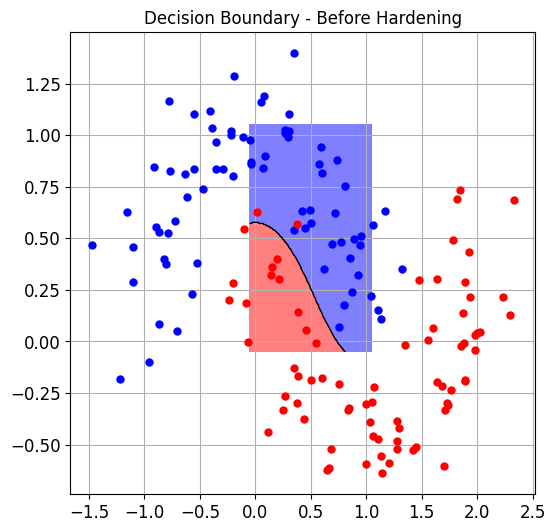

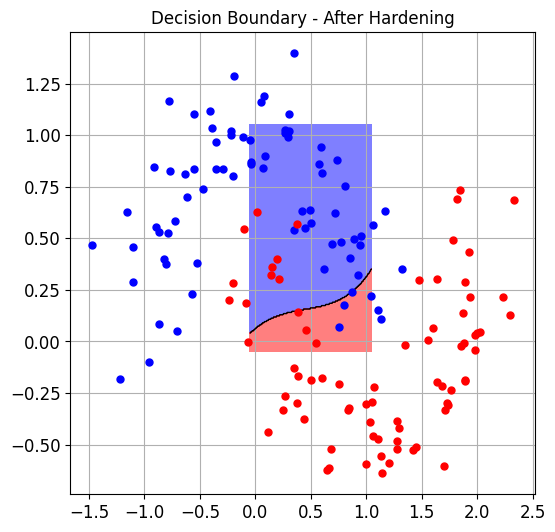

In [52]:
# Plot Decision Boundaries Before and After

def plot_decision_boundary(clf, dataset, title):
    fig = CFigure()
    fig.sp.plot_decision_regions(clf, n_grid_points=200)
    fig.sp.plot_ds(dataset, markersize=5)
    fig.sp.title(title)
    fig.show()

plot_decision_boundary(clf_boundary, ts_toy, "Decision Boundary - Before Hardening")
plot_decision_boundary(clf_hardened_b, ts_toy, "Decision Boundary - After Hardening")

### Gradient Sensitivity Analysis

ts.X shape: (500, 784)


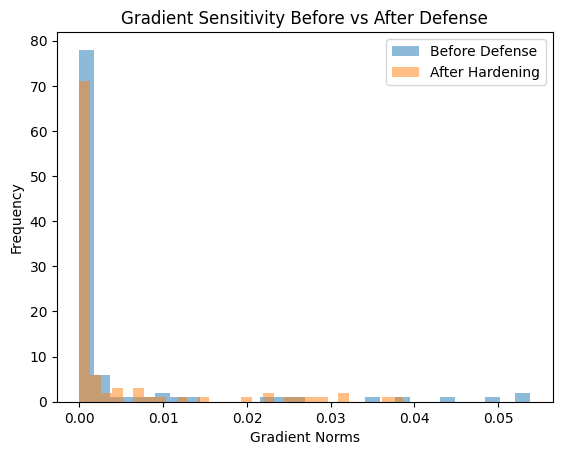

In [53]:
def gradient_norms(clf, X):
    X_tensor = torch.tensor(X.tondarray(), dtype=torch.float32, requires_grad=True).to('cuda')
    X_tensor.retain_grad()  # Retain gradient for non-leaf tensor

    outputs = clf._model(X_tensor)
    target = outputs.max(1)[1]  # Use predicted labels
    loss = torch.nn.CrossEntropyLoss()(outputs, target)

    loss.backward()
    grads = X_tensor.grad.cpu().numpy()
    norms = np.linalg.norm(grads, axis=1)
    return norms
    
print("ts.X shape:", ts.X.shape)

# 100 rows, all 784 columns
idx_rows = CArray.arange(100)
idx_cols = CArray.arange(ts.X.shape[1])  # Should be 784 for MNIST

subset_X_100 = ts.X[idx_rows, idx_cols]

# Evaluate gradient norms
norms_before = gradient_norms(clf, subset_X_100)
norms_after = gradient_norms(hardening_clf, subset_X_100)

plt.hist(norms_before, bins=30, alpha=0.5, label='Before Defense')
plt.hist(norms_after, bins=30, alpha=0.5, label='After Hardening')
plt.xlabel("Gradient Norms")
plt.ylabel("Frequency")
plt.legend()
plt.title("Gradient Sensitivity Before vs After Defense")
plt.show()